# Decomposition Based Approaches to Time Series Forecasting: 

## Prerequisites

Experience with the specific topic: Novice.  
Professional experience: Some industry experience.

Some familiarity with the basic concepts of Time Series forecasting concepts will allow the reader to better follow this tutorial, although advanced knowledge is not required. For a good introduction to the basic concepts of forecasting, see [this tutorial](https://www.datascience.com/blog/time-series-forecasting-machine-learning-differences) and [this tutorial](https://www.datascience.com/blog/introduction-to-forecasting-with-arima-in-r-learn-data-science-tutorials). 

To follow the example, the reader should also be familiar with basic R syntax. R packages needed: forecast, prophet, bsts, ggplot2, and repr.The sample dataset can be downloaded here. 

## Introduction 

In this overview, we would like to introduce decomposition based approaches to time series forecasting. Decompostion based methods are a simple but robust approach to modelling and forecasting time series data. 
The basic idea behind such methods are that they explicitly model the data as a combination of trend, seasonal and remainder components, as opposed to trying to capture temporal dependancies and auto-correlations in the data the way ARIMA or GARCH models do. 

Decomposing a time series model invloves splitting it into 3 or 4 components, in the form of: 

$ \hat{Y}(t) = T(t) + S(t) + R(t) + \epsilon(t) $    *(note that this is an additive decompostion, we will deal with the multiplicative case later)*. 

With:   
$ \hat{Y}(t) $  : The modelled/forecast value at time $t$  
$ T(t) $  : The trend component at time $t$  
$ S(t) $  : The seasonal component at time $t$  
$ R(t) $ : The Remainder at time $t$  
$ \epsilon(t) $ : Error term 

Time series decomposition is usually presented as an analysis step to be perfromed before generating predictions, but it can also be used as a forecasting method in and of itself, if you know before hand what the structure of your time series will look like. Such scenarios occur frequently in a business context, for example in retail demand forecasting, where for some products, it is safe to assume before hand that you sales data will have a yearly seasonal pattern and a year over year trend. 

To forecast a time series using a decomposition model, you calculate the future values for each seperate component and then add them back together to obtain a prediction. The challenge then simply becomes finding the best model for each of the components.

In the following overview, we will present 3 approaches to forecasting using decompostion with R: Seasonal Trend decompostion using LOESS, Bayesian Structural Time Series, and Facebook Prophet. 

First, we will decompose the Air Passengers time series and forecast it using each of the 3 methods. Then we will work on improving the accuracy of the forecasts. 

## Step 1: Load the required libraries and settings

In [1]:
# Call the required libraries 
library(ggplot2)
library(forecast)
library(bsts)
library(prophet)
library(repr)

#Choosing a theme for clear and consistent data plots 
theme_set(theme_bw()) 

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'forecast' was built under R version 3.4.4"Warning message:
"package 'bsts' was built under R version 3.4.4"Loading required package: BoomSpikeSlab
Warning message:
"package 'BoomSpikeSlab' was built under R version 3.4.4"Loading required package: Boom
Warning message:
"package 'Boom' was built under R version 3.4.4"Loading required package: MASS

Attaching package: 'Boom'

The following object is masked from 'package:stats':

    rWishart

Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.4.4"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.4.4"Warning message:
"package 'prophet' was built under R version 3.4.4"Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.4

## Step 2: Load the data 
We will use the air plane passengers data set which is a classic data set for benchmarking time series models first introduced by Box and Jenkins in 1976 (It is to time series forecasting what [the Iris data](https://en.wikipedia.org/wiki/Iris_flower_data_set) set is to classifcation and regression algorithms). In particular the Air Passenger time series has a very clear trend and seasonal pattern  and so is perfect for testing decompostion methods.
This data set is avalailble as part of the base R data package - but it can also be downloaded from [here](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) (in that case you would have to use something like `read.csv()` to load the data and format it as a time series object).

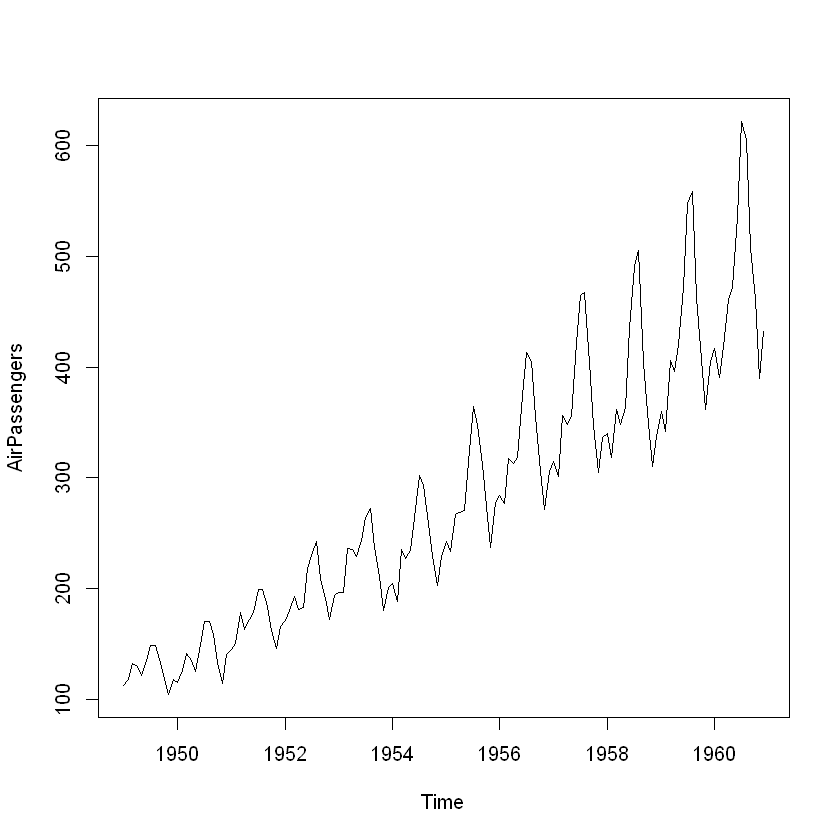

In [2]:
#load the airpassengers data 
data("AirPassengers") 
plot(AirPassengers)

In [3]:
#Split the data into test and train 
train <- window(AirPassengers, end = c(1958, 12))
test <- window(AirPassengers, start = c(1959, 1), end = c(1960,12))

## Step 3: Decompostion and Forecasting

### 3.1 Seasonal Trend decompostion using LOESS (STL) 

The STL was roposed by Cleveland et *al.* in 1990. STL uses the [LOESS (**LO**cal regr**ESS**ion) method](https://en.wikipedia.org/wiki/Local_regression) to model the trend and seasonal components using polynomial regression. The algorithm works by running two loops: 
- An outer loop were robustness coeifficients are calcualted to minimize the effect of outliers.
- An inner loop were the trend component and seasonal component are iteratively updated using LOESS smoothing. 

The algorithm can be set to run for a fixed number of iterations for each loop, or it can be set to run until a specific convergence criterion is met (in the R versions of STL presented here, we will use the default number of fixed iterations which is 2). In addition, we can specify to STL whether we want the seasonal component to remain constant over time or whether we want to change (in R this can be specified using the paramter `s.window`).

To forecast with STL, we first use STL to decompose the time series into 3 components:  
$ \hat{Y}(t) = T(t) + S(t) + R(t) $  

We then apply a standard forecasting algorithm to the remainder $R(t)$, such as ARIMA or Exponential Smoothing, and generate an h-step ahead forecast for the remainder component $R(t+h)$.

Lastly we calculate the h-step ahead trend component $T(t+h)$ and $S(t+h)$ and sum all three components to obtain a final forecast. 

If we want ot use STL for analysis only, then the `STL()` function that comes with the base R installation is sufficient. To use STL for forecasting however, it is easier to use the `STLF()` in the Forecast package, which uses the original `STL()` function for decomposition but also allows us to specify which algorithm to use for forecasting the remainder. 

To perform an STL decomposition, you can run:

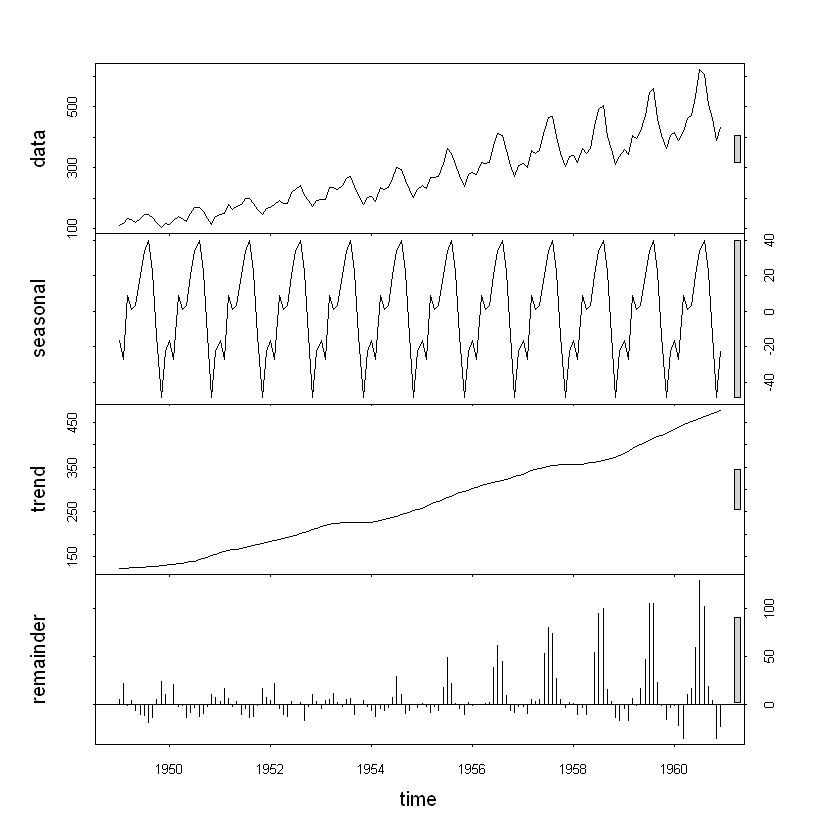

In [4]:
#Decompose the time series 
AirPassengersSTL <- stl(AirPassengers, s.window="periodic", robust=TRUE)
plot(AirPassengersSTL)

Note that you don't need to pass a number of seasons to the STL() function, it is picking it up from the frequency that is defined in the original time series object `AirPassengers`.

To generate forecasts, you can use `STLF()`, which allows you to specify which algorithm to use for forecasting the remainder. In this case we will use ARIMA, we don't need to specify the ARIMA orders (p,q,d) - the forecast method will find the optimal orders on its own. 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


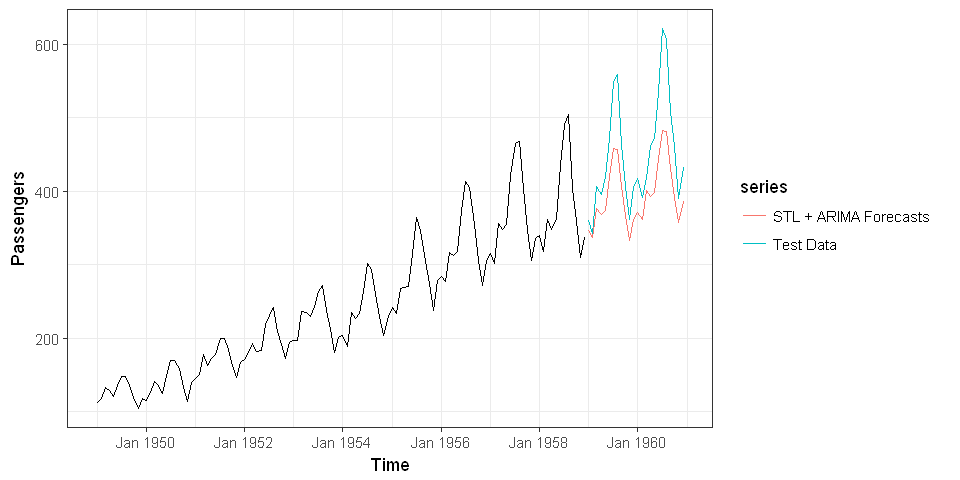

In [5]:
#Train the STL model, using ARIMA to forecast the remainder 
AirPassengersSTL_ARIMA <- stlf(train, method="arima")
#Plot the results
options(repr.plot.width=8, repr.plot.height=4)
autoplot(train , ylab = 'Passengers') + scale_x_yearmon() + autolayer(test, series="Test Data") +
  autolayer(ts(AirPassengersSTL_ARIMA$mean,frequency=12, start=c(1959,1)), series="STL + ARIMA Forecasts")

### 3.2 Bayesian Structural Time Series 


Proposed by Scott and Varian in 2013, Bayesian Structural Time Series are a powerful set of methods that cover a large class of time series models using the [State Space representation](https://en.wikipedia.org/wiki/State-space_representation) of time series and Bayesian statistics. 

In the State Space approach, a time series can be written as a set of two equations, a state equation describing the overal evolution of the system in terms of unobserved states, and an observation or measurment euqation describing the relationship between the observable variables and the hidden states. 

$\alpha(t+1) = T(t) \, \alpha(t) + R(t)\, \eta(t)$ :   The state equation, with $\alpha(t)$ the state of the system at time $t$.  
$\hat{Y}(t) = Z^T(t)\,  \alpha(t) + \epsilon(t) $ :   The observation equation relating the values of the time series to the hidden states. 


It is straightforward to rewrite the trend and seasonal decompostion of a time series:


$\hat{Y}(t) = T(t) + S(t) + \epsilon(t) $ 

(A BSTS model can also include a set of external regressors $\beta \, X(t)$, although we don't so so here) 

In state space form: 


$\hat{Y}(t) = Z^T(t) \,  \alpha(t) + \epsilon(t) $ 

With:  

$\alpha(t) = \begin{bmatrix} 
    T(t) \\
    S(t) 
    \end{bmatrix} $ 
    
and $Z(t) = [1 \: 1]$  

And the state equation is: 

$ T(t) = T(t-1) + u(t) $  
$ S(t) = - \sum_{i= 1}^{N - 1}{S(t-i)} + w(t) $ (with $S(t-i)$ a set of seasonal dummy variables used to model seasonality). (i.e $\eta(t) = u(t) + w(t)$). 

[Kalman filtering](https://en.wikipedia.org/wiki/Kalman_filter) and an [MCMC algorithm](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) are used to fit the model. Forecast are then calculated from the posterior predictive distribution.  

Let's fit a BSTS model on our data and then plot the components: 

In [6]:
#Train the BSTS model 
Trend_Seasonal_states <- AddSemilocalLinearTrend(list(),train)
Trend_Seasonal_states <- AddSeasonal(Trend_Seasonal_states,train, nseasons = 12)
AirPassengersBSTS <- bsts(train,state.specification = Trend_Seasonal_states, niter = 1000)

=-=-=-=-= Iteration 0 Mon Jul 09 11:10:20 2018
 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Jul 09 11:10:21 2018
 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Jul 09 11:10:21 2018
 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Jul 09 11:10:21 2018
 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Jul 09 11:10:21 2018
 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Jul 09 11:10:21 2018
 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Jul 09 11:10:21 2018
 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Jul 09 11:10:22 2018
 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Jul 09 11:10:22 2018
 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Jul 09 11:10:22 2018
 =-=-=-=-=


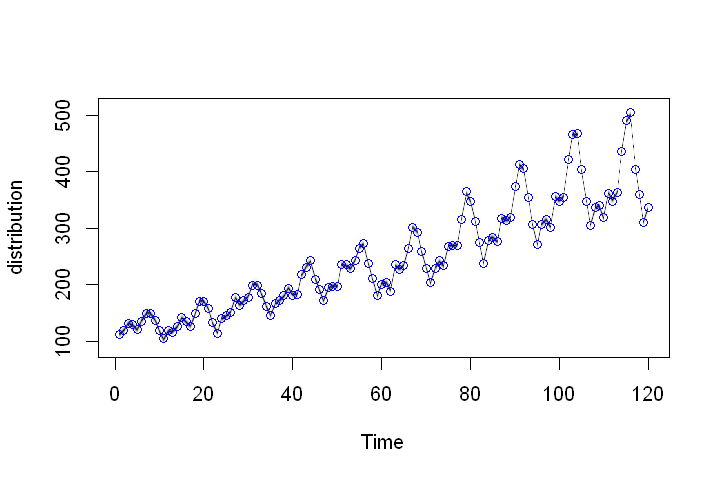

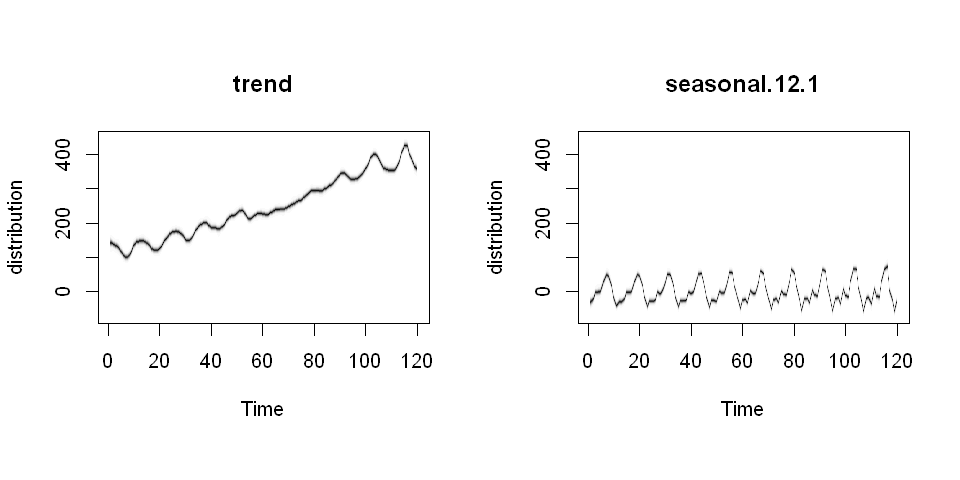

In [7]:
options(repr.plot.width=6, repr.plot.height=4)
plot(AirPassengersBSTS)
options(repr.plot.width=8, repr.plot.height=4)
plot(AirPassengersBSTS, "components")

To generate forecasts and plot the results:

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


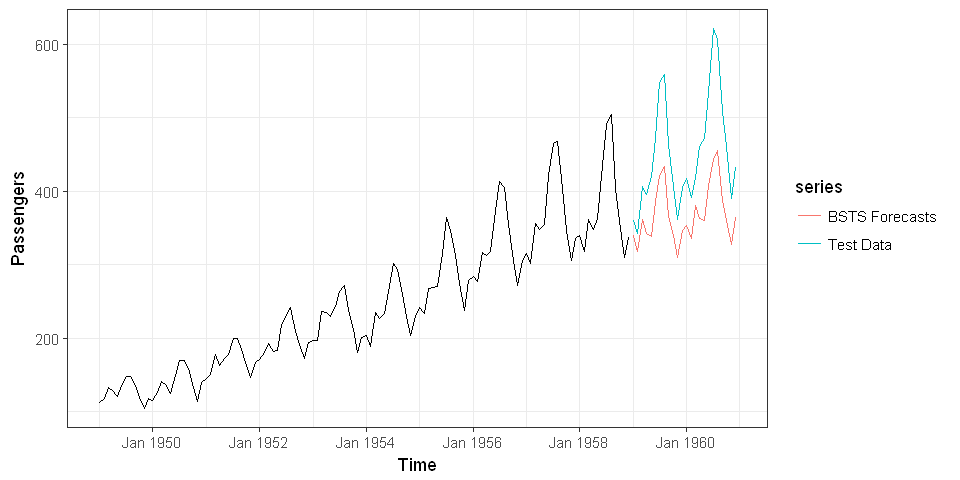

In [8]:
BSTSForecasts <- predict.bsts(AirPassengersBSTS, horizon = 24)
BSTSForecastsFormatted <- ts(BSTSForecasts$mean,frequency=12, start=c(1959,1))
options(repr.plot.width=8, repr.plot.height=4)
autoplot(train , ylab = 'Passengers') + scale_x_yearmon() + autolayer(test, series="Test Data") +
  autolayer(BSTSForecastsFormatted, series="BSTS Forecasts")

### 3.3 Facebook Prophet 

Prophet is a forecasting method developped at Facebook, which they open sourced in 2017. It is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses [Generalized Additive Models](https://en.wikipedia.org/wiki/Generalized_additive_model) instead of a State Space representation to describe each component. 

Similar to the other 2 approaches, a basic prophet model is written as: 

$\hat{Y}(t) = T(t) + S(t) + H(t) + \epsilon(t) $ 

with $T(t)$ the trend, $S(T)$ the seasonality and $H(T)$ an additional component to represent Holiday effects. 

The rend is modelled either as a logistic growth model for time series with saturated growth: 

$T(t) = \frac{C}{1 + exp(-k(t))}$ with $C$ the capacity of the model (i.e. maximum level of the time series). 

Or a piece-wise linear growth model for unbounded growths:  

$T(t) = kt $

Changes in trend are modelled using changepoints in the growth rate $k$. 

The seasonal component is modelled using a Fourier series: 

$S(t) = \sum_{n=1}^{N}{(a_n cos(\frac{2\pi nt}{P}) + b_n cos(\frac{2\pi nt}{P}))}$ with $P$ the period of the time series (365 days for yearly data, 7 days for weekly data, etc...) and $a$ and $b$ are models to be estimating. 

The holdiay component $H(t)$ is modelled as a regression on the specific holiday dates (which would have to be provided seperately - although we won't cover that here). 

The [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) agorithm is ued to fit the model. 

Facebook Prophet works great out if the box and is very intuitive, especially for non specialists with no time series or data science training, but it has very rigid requirements in the way the data should be formated. The time series data needs to be passed to the function as dataframe with a column 'ds' for date and 'y' for data. 

So the first step in training a Prophet model will to be format the data properly:

In [9]:
#Create a data frame in the right format for Prophet
FBTrain <- data.frame(ds = as.Date(as.yearmon(time(train))), y=as.matrix(train))

To fit a Propbhet model to the data:

In [10]:
#Generate a model and then generate forecasts 
m <- prophet(FBTrain,yearly.seasonality=TRUE) 

Warning message:
"package 'bindrcpp' was built under R version 3.4.4"Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.
Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -2.56207
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Prophet also requires that a future time dataframe be defined, before generating forecasts: 

In [11]:
future <- make_future_dataframe(m, periods = 24, freq = 'month')
forecast <- predict(m, future)

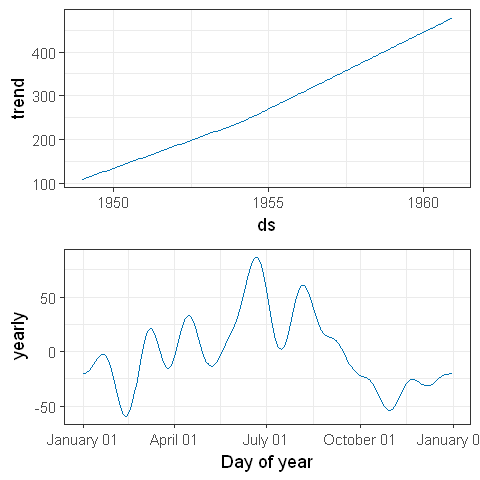

In [12]:
#Plot the components 
options(repr.plot.width=4, repr.plot.height=4)
prophet_plot_components(m,forecast)

Finally you can plot the forecasts. Note that Prophet comes with it's own plotting function, but we will be using `autoplot` from the forecast package so as to keep our plots consistent: 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


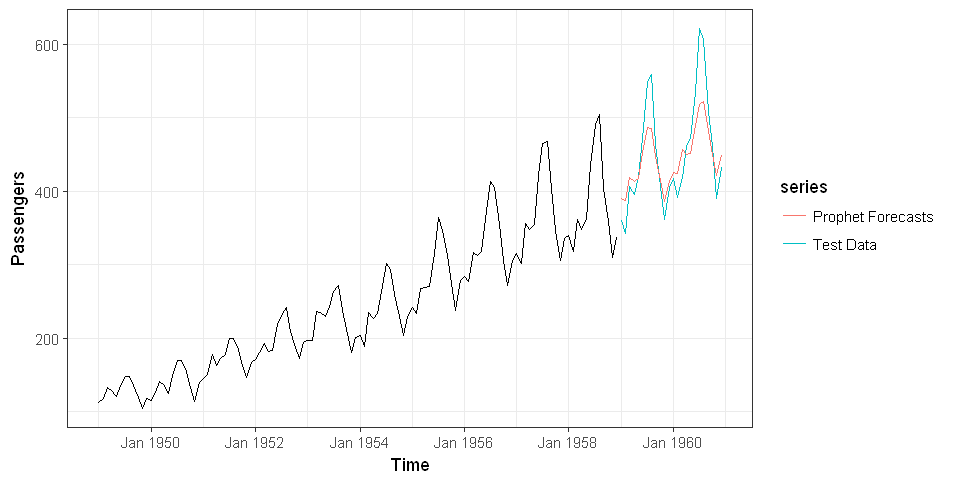

In [13]:
#Plot the results 
ProphetForecast <- ts(forecast$yhat,frequency=12, start=c(1949,1))
ProphetForecast <- window(ProphetForecast, start = c(1959, 1), end = c(1960,12))
options(repr.plot.width=8, repr.plot.height=4)
autoplot(train , ylab = 'Passengers') + scale_x_yearmon() + autolayer(test, series="Test Data") +
  autolayer(ProphetForecast, series="Prophet Forecasts")

## Step 4: Improving Accuracy 

The forecasts that we have generated so far using these three approaches are "OK" - they seem to follow the general trend of the time series and they also replicated the seasonal patter in the data. But they still seem to fail to capture the increase in the magnitude of the seasonal variation over time. This because the Air Passengers time series has more of a multiplicative seasonal pattern than an additive one. In the next section we will try to overcome this difficulty by applying a log transform to the data so that multiplicative seasonality can be represented by an additive model. We will rerun each of the forecasting methods on the log transformed data, and then reverse transform the resulting forecats and compare them to the original data. 

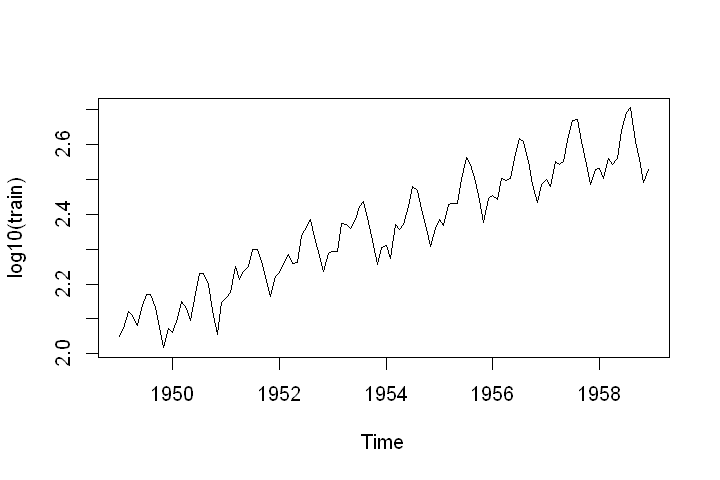

In [14]:
#Plot the log transformed data - you can see that the seasonality is more additive now. 
options(repr.plot.width=6, repr.plot.height=4)
plot(log10(train))

### 4.1 STL with log transformed data

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


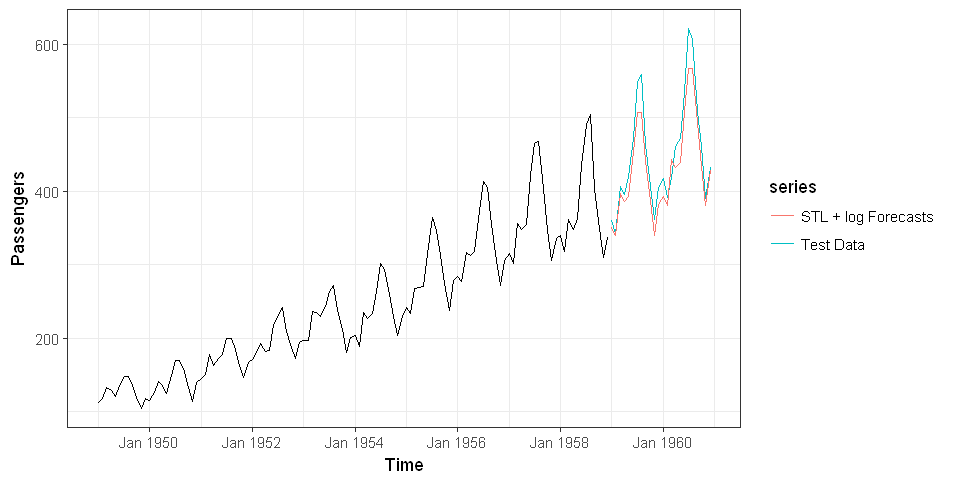

In [15]:
AirPassengersSTL_ARIMA_log <- stlf(log10(train),method="arima")
options(repr.plot.width=8, repr.plot.height=4)
autoplot(train , ylab = 'Passengers') + scale_x_yearmon() + autolayer(test, series="Test Data") +
  autolayer(ts(10^as.numeric(AirPassengersSTL_ARIMA_log$mean),frequency=12, start=c(1959,1)), series="STL + log Forecasts")

In [16]:
#Train the BSTS model 
Trend_Seasonal_states_log <- AddGeneralizedLocalLinearTrend(list(),log10(train))
Trend_Seasonal_states_log <- AddSeasonal(Trend_Seasonal_states_log,train,nseasons=12)
AirPassengersBSTS_log <- bsts(log10(train),state.specification = Trend_Seasonal_states_log, niter = 1000)

Warning message in AddGeneralizedLocalLinearTrend(list(), log10(train)):
"AddGeneralizedLocalLinearTrend is deprecated (because it was a terrible name!). Please use AddSemilocalLinearTrend instead."

=-=-=-=-= Iteration 0 Mon Jul 09 11:14:00 2018
 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Jul 09 11:14:00 2018
 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Jul 09 11:14:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Jul 09 11:14:02 2018
 =-=-=-=-=


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


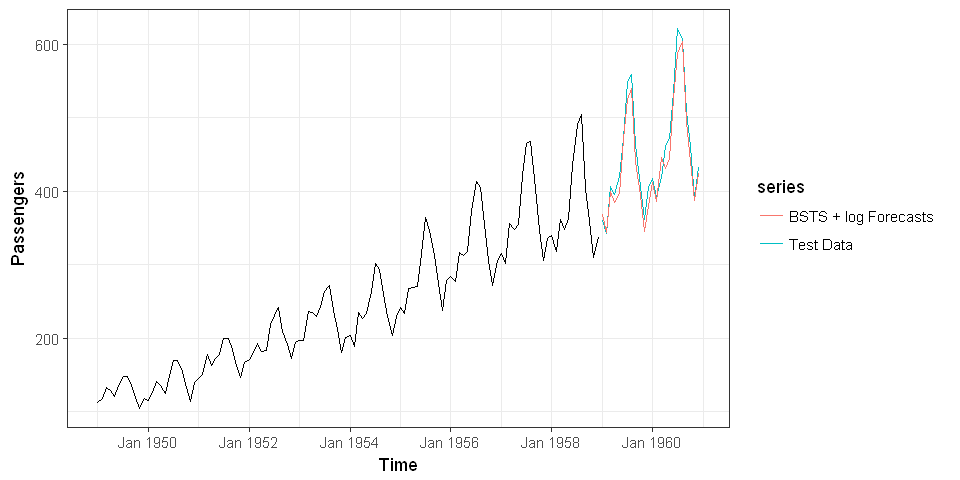

In [17]:
BSTSForecasts_log <- predict.bsts(AirPassengersBSTS_log, horizon = 24, quantiles = c(0.0000001, 0.000001))
options(repr.plot.width=8, repr.plot.height=4)
autoplot(train , ylab = 'Passengers') + scale_x_yearmon() + autolayer(test, series="Test Data") +
  autolayer(ts(10^as.numeric(BSTSForecasts_log$mean),frequency=12, start=c(1959,1)), series="BSTS + log Forecasts")

In [18]:
#Create a data frame in the right format for Prophet
FBTrain_log <- data.frame(ds = as.Date(as.yearmon(time(train))), y=as.matrix(log10(train)))

In [19]:
#Generate a model and then generate forecasts 
m <- prophet(FBTrain_log,yearly.seasonality=TRUE , seasonality.prior.scale = 2) 
future <- make_future_dataframe(m, periods = 24, freq = 'month')
forecast <- predict(m, future)

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.
Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -2.08326
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


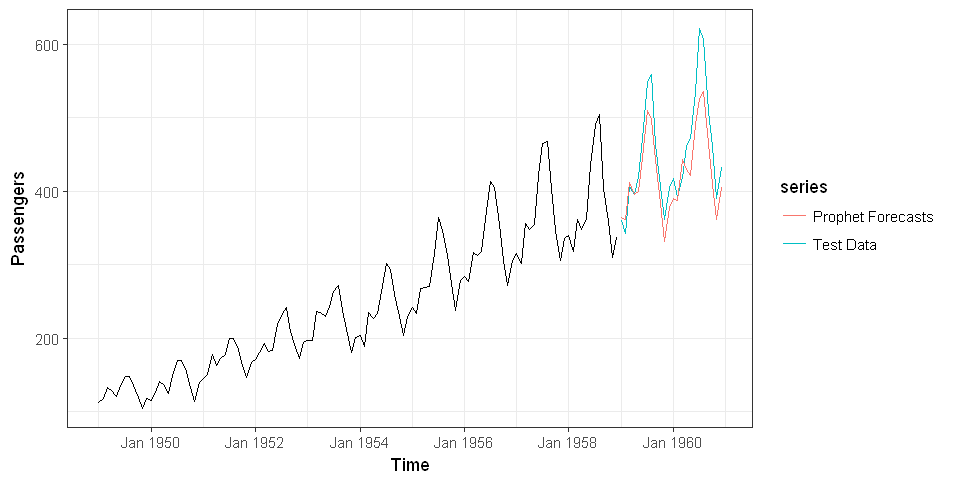

In [20]:
ProphetForecast <- ts(10^as.numeric(forecast$yhat),frequency=12, start=c(1949,1))
ProphetForecast <- window(ProphetForecast, start = c(1959, 1), end = c(1960,12))
options(repr.plot.width=8, repr.plot.height=4)
autoplot(train , ylab = 'Passengers') + scale_x_yearmon() + autolayer(test, series="Test Data") +
  autolayer(ProphetForecast, series="Prophet Forecasts")

In all 3 cases, we can see that using the log transform improved the accuracy of the forecasts for all three methos, although BSTS seems to perfrom better than the other two methods. 

## 5 Some notes:  

- We didn't mention forecast intervals in this overview, we only generated point forecasts. In many business scenarios, such as demand forecasting and supply chain planning, the forecast intervals are just as important as the point forecasts. Each of the R functions used allows you to generate forecast intervals as well.  

- We informaly evaluated the performance of the forecast methods based on plots of forecasts vs actuals for hold out test data. A more rigourous analysis of these methods perfroamce would require the calculation of forecast error metrics like MAPE and RMSE. 

- In the Air Passengers data set, there is only one yearly seasonal component. But several business time series can have multiple seasonalities. For example a restaurant customer time series will have daily seasonality (with peakes at lunch time and dinner time) and weekly seasonality (less customers on weekends). STL cannot handle more than one seasonal component. Prophet can handle multiple seasonalities, although as mentioned above it requires specific date formats. BSTS can hanle multiple seasonalities by using a Fourier series (the same way as prophet) for representing the seasonal component, (Call `AddTrig` instead of `AddSeasonal`).   

- STL in its basic form doesn't allow for hoiday effects, although the version of STL that is available in R Forecast package can take in holidays as exogenous variables input into the forecast method that is used for modelling the remainder. 

- Prophet and BSTS can both handle holiday effects. In Prophet this is explicit and all you need to do is provide a dataframe with the holiday dates. In BSTS you need to model the holidays as a set of external regressors.   

- BSTS full potential is realized when we add additional data beyond the time series and holiday data. For example, for the Air Passenger data, we could add additional factors such as economic conditions, Airline marketing data, number of internet queries for air plane trips, etc...and then Bayesian modelling can be used to improve the accuracy of the forecats. In particular, BSTS is very useful for "Nowcasting" - predicting the values of time series in the present. In the Air Passenger data example, it would take several months for the air lines to compile and release the data, so you can't know the value for the current month untill several months into the future. If however you needed to forecast the number of air passengers for the current month, and you couldn't afford to wait, you could use the above mentioned external data along with historical values of the air passenger traffic and "nowcast" the number of air passengers for the current month.  

## 6 Conclusion: 

In this overview, we introduced 3 decompostion based approaches to forecasting, and showed how they can be used as simple, easily interpratable, but also robust, methods for univariate time series forecasting. 

## References: 
- Cleveland et *al.*, "STL: A Seasonal-Trend Decomposition", 1990 
- Scott & Varian, "Predicting the present with Bayesian structural time series", (2013).  
- Taylor & Letham,  "Forecasting at scale", 2017